In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from itertools import chain
import seaborn as sns
from datetime import datetime

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import resample_img
from nilearn.image import new_img_like, load_img, clean_img, crop_img
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import torch.optim as optim
import h5py
from torchsummary import summary
from tensorboardX import SummaryWriter

from IPython import display
%matplotlib inline

In [2]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class MyDataset(Dataset):
    def __init__(self, task_type, test_size=0.2, test=False, scaler='minmax',
                path='../../brainmask_tlrc/*.npy'):

        self.scaler = scaler

        RANDOM_STATE = 42
        np.random.seed(RANDOM_STATE)

        data_files = glob(path)
        data_files.sort()
        
#         label_file = pd.read_csv('../rsc/age_ixi_and_oasis.csv', index_col=0)
        label_file = pd.read_csv('../rsc/age_ixioasdlbs.csv', index_col=0)
        
        idx = label_file[label_file.src.map(lambda x: x not in ['Oasis3'])].index
        data_files = np.array(glob('../../brainmask_tlrc/*.npy'))
        data_files.sort()
        data_files = data_files[idx].tolist()

        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))

        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname = [data_files[i] for i in shuffled_index[-test_num:]]
        

        if test:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file[task_type].values[shuffled_index[-test_num:]]
            self.fname = label_file['id'].values[shuffled_index[-test_num:]]

        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file[task_type].values[shuffled_index[:train_num]]
            self.fname = label_file['id'].values[shuffled_index[:train_num]]

    def __getitem__(self, idx):
        
        if self.scaler == 'minmax':
            x = np.load(self.data_files[idx])
            x = MinMaxScaler().fit_transform(x.reshape(-1, 1)).reshape(141, 172, 110)

        else:
            x = np.load(self.data_files[idx])
            
        x = torch.tensor(x)[None, :, :].float()
        y = torch.tensor(self.label_file[idx]).float()
        
        return x, y

    def __len__(self):
        return len(self.data_files)

In [3]:
train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

In [4]:
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F


def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=400):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [5]:
class Option:
    
    def __init__(self, model_depth=10,
                n_classes=1,
                n_input_channels=1,
                conv1_t_size=3,
                conv1_t_stride=1,
                no_max_pool=False,
                resnet_widen_factor=1.0
                ):
        
        self.model_depth = model_depth
        self.n_classes = n_classes
        self.n_input_channels = n_input_channels
        self.conv1_t_size = conv1_t_size
        self.conv1_t_stride = conv1_t_stride
        self.no_max_pool = no_max_pool
        self.resnet_widen_factor = resnet_widen_factor

opt = Option()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = generate_model(model_depth=opt.model_depth,
                              n_classes=opt.n_classes,
                              n_input_channels=opt.n_input_channels,
#                               shortcut_type=opt.resnet_shortcut,
                              conv1_t_size=opt.conv1_t_size,
                              conv1_t_stride=opt.conv1_t_stride,
                              no_max_pool=opt.no_max_pool,
                              widen_factor=opt.resnet_widen_factor)
model.to(device)

summary(model, input_size=(1, 141, 172, 110))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 64, 141, 86, 55]           9,408
       BatchNorm3d-2      [-1, 64, 141, 86, 55]             128
              ReLU-3      [-1, 64, 141, 86, 55]               0
         MaxPool3d-4       [-1, 64, 71, 43, 28]               0
            Conv3d-5       [-1, 64, 71, 43, 28]         110,592
       BatchNorm3d-6       [-1, 64, 71, 43, 28]             128
              ReLU-7       [-1, 64, 71, 43, 28]               0
            Conv3d-8       [-1, 64, 71, 43, 28]         110,592
       BatchNorm3d-9       [-1, 64, 71, 43, 28]             128
             ReLU-10       [-1, 64, 71, 43, 28]               0
       BasicBlock-11       [-1, 64, 71, 43, 28]               0
           Conv3d-12      [-1, 128, 36, 22, 14]         221,184
      BatchNorm3d-13      [-1, 128, 36, 22, 14]             256
             ReLU-14      [-1, 128, 36,

In [6]:
task_type = 'age'
resize = False
scheduler = False

summary = SummaryWriter(f'./tensorboard/{datetime.now().strftime("%Y-%m-%d_%H%M")}')

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
LOSS = {
    'RMSE': RMSELoss(),
    'MSE': nn.MSELoss(),
}

In [7]:
# loss_fn = nn.MSELoss()
loss = 'RMSE'

loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS 0
RMSE :: [TRAIN] 51.606 | [VALID] 49.842
CORR :: [TRAIN] 0.022 | [VALID] -0.007


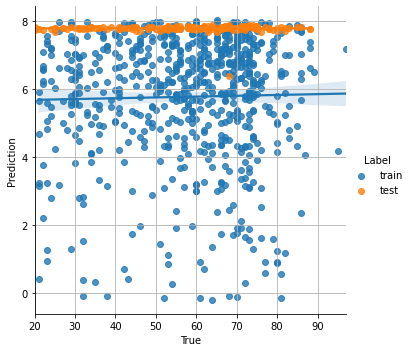

EPOCHS 1
RMSE :: [TRAIN] 47.832 | [VALID] 46.723
CORR :: [TRAIN] 0.061 | [VALID] -0.002


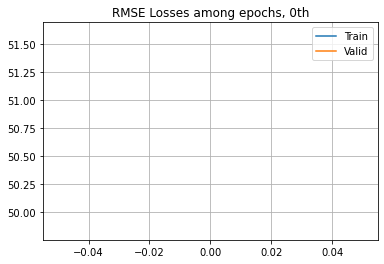

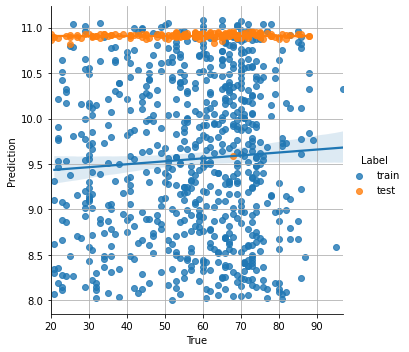

EPOCHS 2
RMSE :: [TRAIN] 44.749 | [VALID] 43.518
CORR :: [TRAIN] 0.065 | [VALID] -0.025


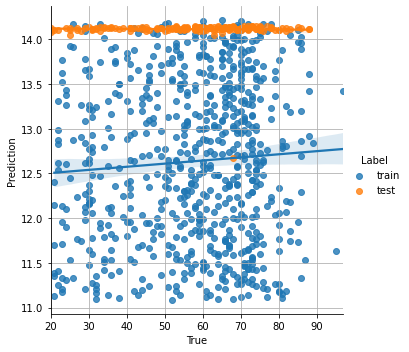

EPOCHS 3
RMSE :: [TRAIN] 41.565 | [VALID] 40.234
CORR :: [TRAIN] 0.064 | [VALID] -0.041


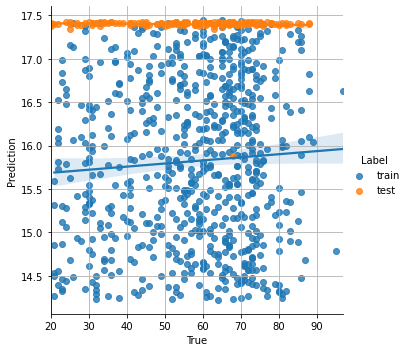

EPOCHS 4
RMSE :: [TRAIN] 38.267 | [VALID] 36.835
CORR :: [TRAIN] 0.064 | [VALID] -0.048


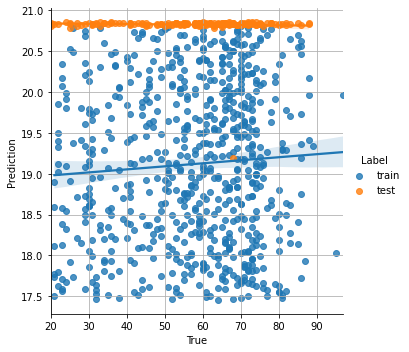

EPOCHS 5
RMSE :: [TRAIN] 34.875 | [VALID] 33.467
CORR :: [TRAIN] 0.124 | [VALID] 0.373


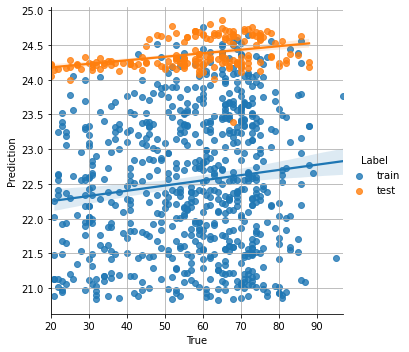

EPOCHS 6
RMSE :: [TRAIN] 31.674 | [VALID] 29.946
CORR :: [TRAIN] 0.286 | [VALID] 0.428


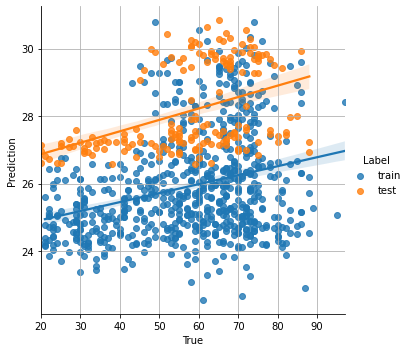

EPOCHS 7
RMSE :: [TRAIN] 28.459 | [VALID] 27.054
CORR :: [TRAIN] 0.352 | [VALID] 0.456


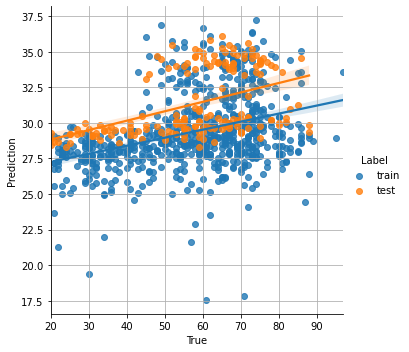

EPOCHS 8
RMSE :: [TRAIN] 25.273 | [VALID] 24.436
CORR :: [TRAIN] 0.426 | [VALID] 0.463


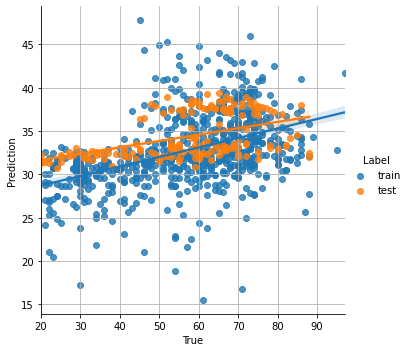

EPOCHS 9
RMSE :: [TRAIN] 21.984 | [VALID] 19.992
CORR :: [TRAIN] 0.510 | [VALID] 0.623


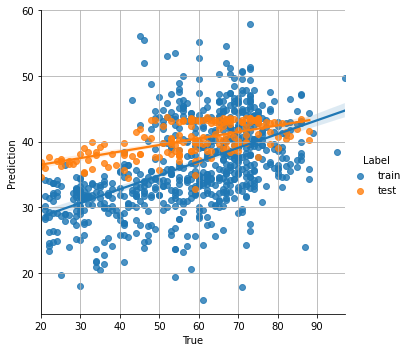

EPOCHS 10
RMSE :: [TRAIN] 18.598 | [VALID] 16.008
CORR :: [TRAIN] 0.581 | [VALID] 0.639


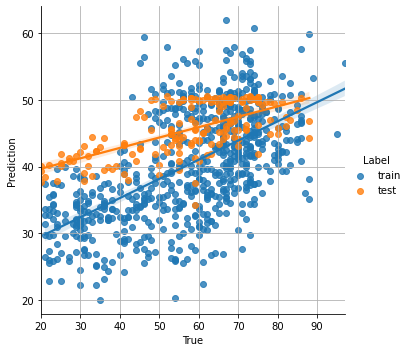

EPOCHS 11
RMSE :: [TRAIN] 15.695 | [VALID] 14.107
CORR :: [TRAIN] 0.635 | [VALID] 0.722


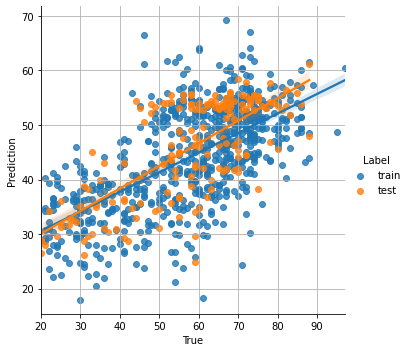

EPOCHS 12
RMSE :: [TRAIN] 13.321 | [VALID] 18.066
CORR :: [TRAIN] 0.678 | [VALID] 0.666


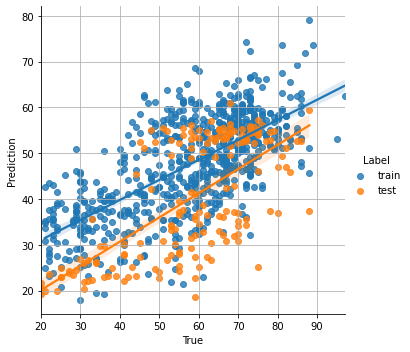

EPOCHS 13
RMSE :: [TRAIN] 11.091 | [VALID] 18.474
CORR :: [TRAIN] 0.731 | [VALID] 0.659


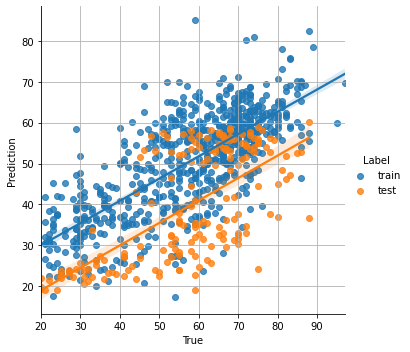

EPOCHS 14
RMSE :: [TRAIN] 9.669 | [VALID] 17.909
CORR :: [TRAIN] 0.760 | [VALID] 0.669


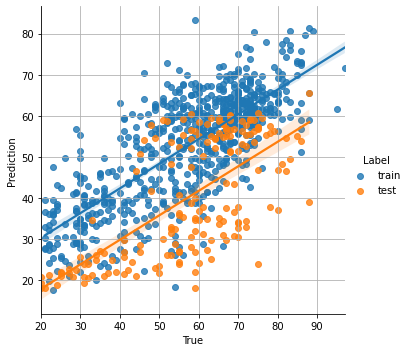

EPOCHS 15
RMSE :: [TRAIN] 8.922 | [VALID] 11.649
CORR :: [TRAIN] 0.768 | [VALID] 0.776


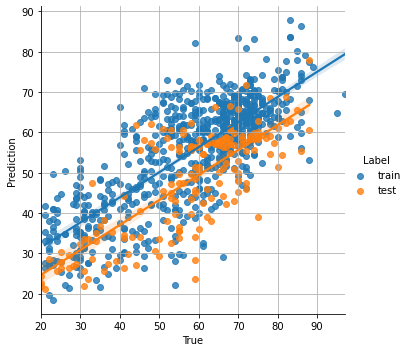

EPOCHS 16
RMSE :: [TRAIN] 8.029 | [VALID] 7.928
CORR :: [TRAIN] 0.804 | [VALID] 0.797


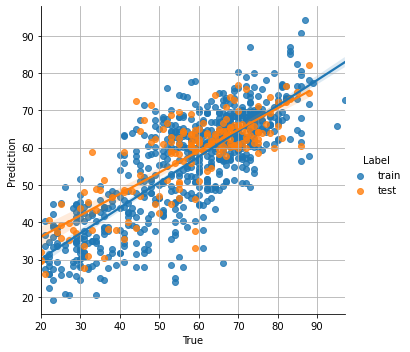

EPOCHS 17
RMSE :: [TRAIN] 7.627 | [VALID] 8.064
CORR :: [TRAIN] 0.815 | [VALID] 0.799


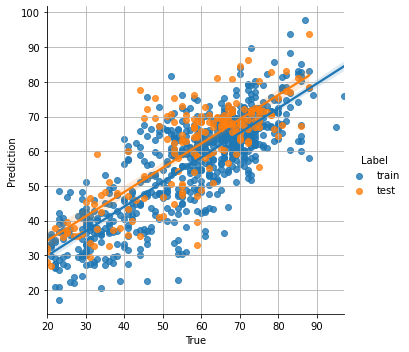

EPOCHS 18
RMSE :: [TRAIN] 7.060 | [VALID] 7.774
CORR :: [TRAIN] 0.837 | [VALID] 0.813


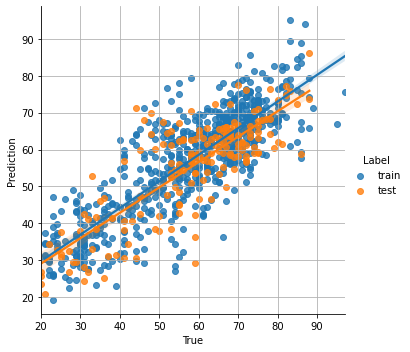

EPOCHS 19
RMSE :: [TRAIN] 6.877 | [VALID] 8.177
CORR :: [TRAIN] 0.842 | [VALID] 0.776


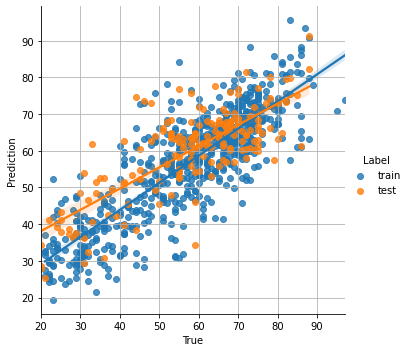

EPOCHS 20
RMSE :: [TRAIN] 6.498 | [VALID] 8.088
CORR :: [TRAIN] 0.858 | [VALID] 0.792


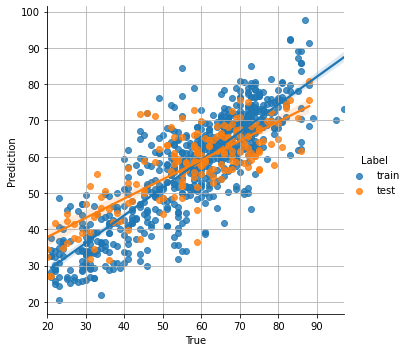

EPOCHS 21
RMSE :: [TRAIN] 6.068 | [VALID] 7.835
CORR :: [TRAIN] 0.872 | [VALID] 0.810


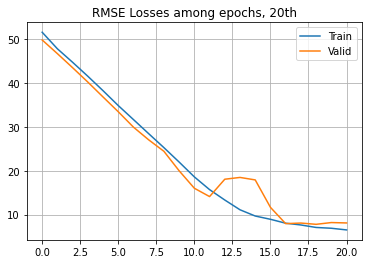

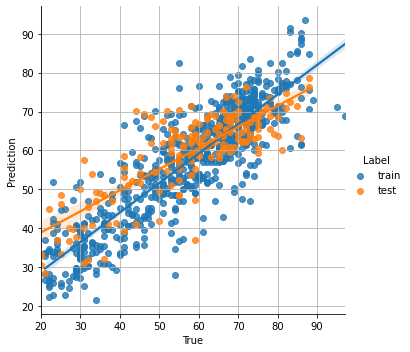

EPOCHS 22
RMSE :: [TRAIN] 6.110 | [VALID] 9.123
CORR :: [TRAIN] 0.869 | [VALID] 0.719


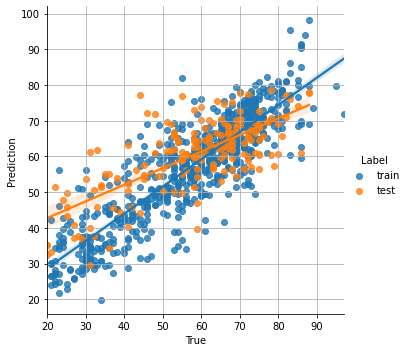

EPOCHS 23
RMSE :: [TRAIN] 5.590 | [VALID] 8.515
CORR :: [TRAIN] 0.888 | [VALID] 0.749


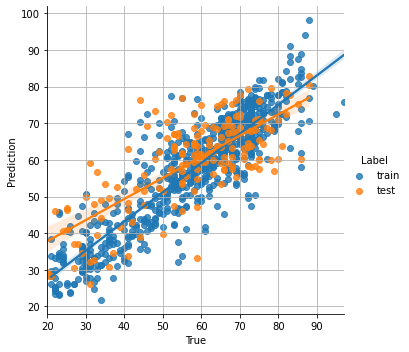

EPOCHS 24
RMSE :: [TRAIN] 5.237 | [VALID] 9.839
CORR :: [TRAIN] 0.900 | [VALID] 0.716


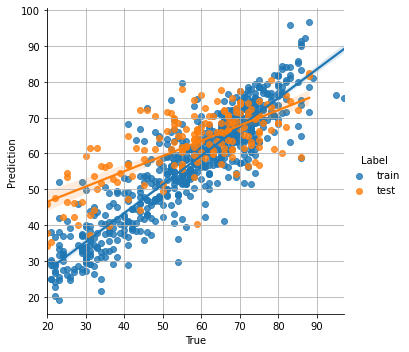

EPOCHS 25
RMSE :: [TRAIN] 5.760 | [VALID] 8.138
CORR :: [TRAIN] 0.885 | [VALID] 0.771


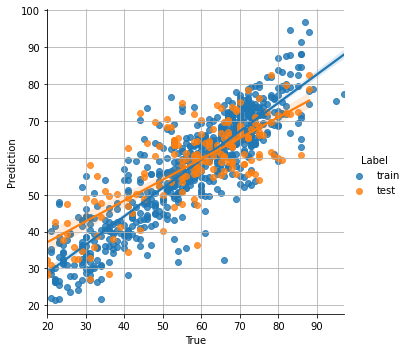

EPOCHS 26
RMSE :: [TRAIN] 5.225 | [VALID] 9.668
CORR :: [TRAIN] 0.899 | [VALID] 0.781


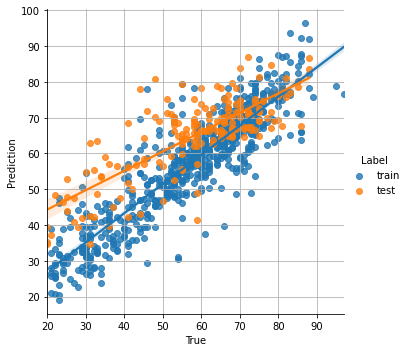

EPOCHS 27
RMSE :: [TRAIN] 5.391 | [VALID] 13.617
CORR :: [TRAIN] 0.897 | [VALID] 0.499


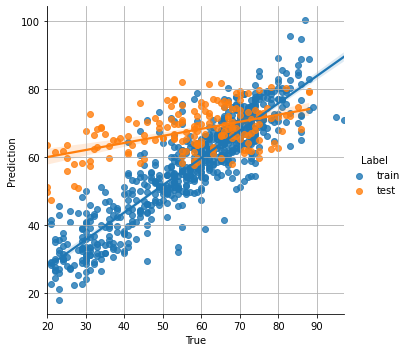

EPOCHS 28
RMSE :: [TRAIN] 5.328 | [VALID] 16.598
CORR :: [TRAIN] 0.901 | [VALID] 0.550


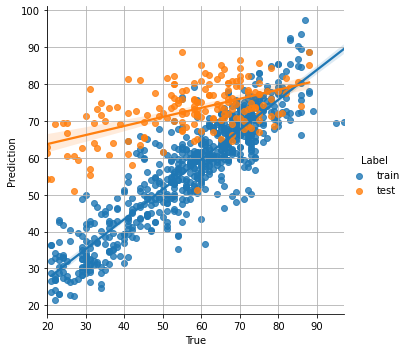

EPOCHS 29
RMSE :: [TRAIN] 4.901 | [VALID] 11.319
CORR :: [TRAIN] 0.910 | [VALID] 0.768


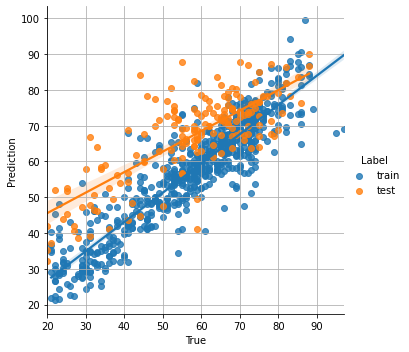

EPOCHS 30
RMSE :: [TRAIN] 4.781 | [VALID] 10.909
CORR :: [TRAIN] 0.918 | [VALID] 0.768


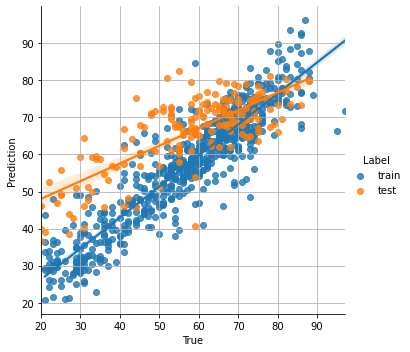

EPOCHS 31
RMSE :: [TRAIN] 4.665 | [VALID] 11.473
CORR :: [TRAIN] 0.921 | [VALID] 0.803


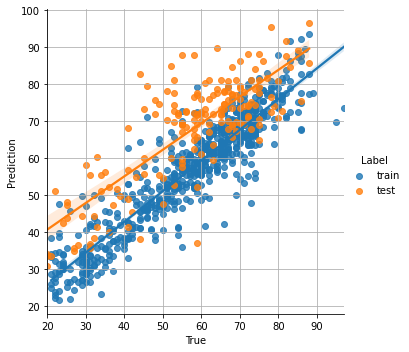

EPOCHS 32
RMSE :: [TRAIN] 4.502 | [VALID] 8.188
CORR :: [TRAIN] 0.928 | [VALID] 0.828


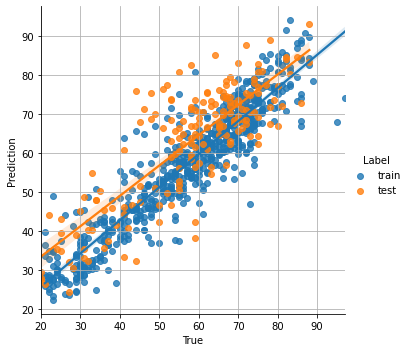

EPOCHS 33
RMSE :: [TRAIN] 4.485 | [VALID] 7.566
CORR :: [TRAIN] 0.929 | [VALID] 0.813


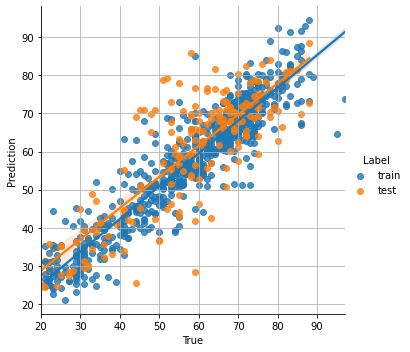

EPOCHS 34
RMSE :: [TRAIN] 4.263 | [VALID] 7.741
CORR :: [TRAIN] 0.935 | [VALID] 0.837


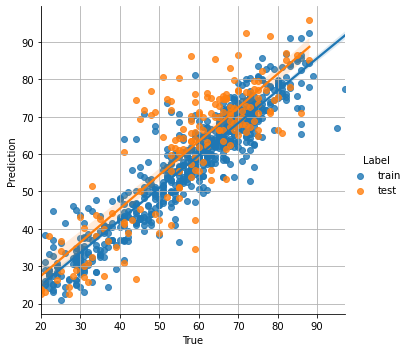

EPOCHS 35
RMSE :: [TRAIN] 4.134 | [VALID] 8.049
CORR :: [TRAIN] 0.938 | [VALID] 0.808


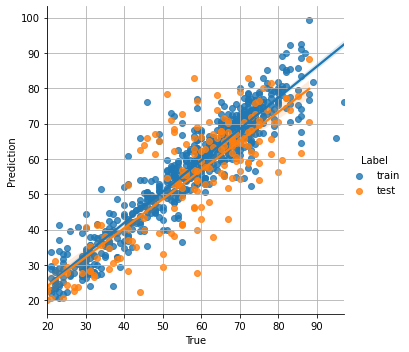

EPOCHS 36
RMSE :: [TRAIN] 4.032 | [VALID] 7.489
CORR :: [TRAIN] 0.940 | [VALID] 0.825


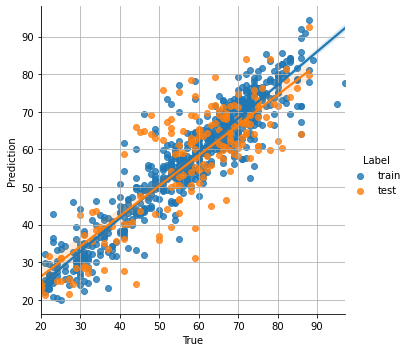

EPOCHS 37
RMSE :: [TRAIN] 3.712 | [VALID] 7.526
CORR :: [TRAIN] 0.948 | [VALID] 0.809


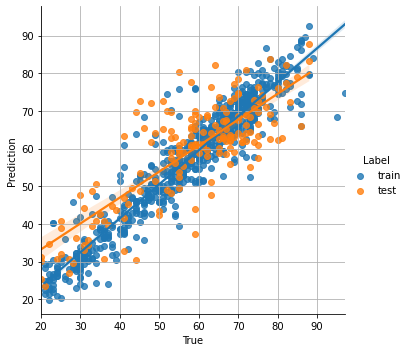

EPOCHS 38
RMSE :: [TRAIN] 3.717 | [VALID] 8.153
CORR :: [TRAIN] 0.948 | [VALID] 0.799


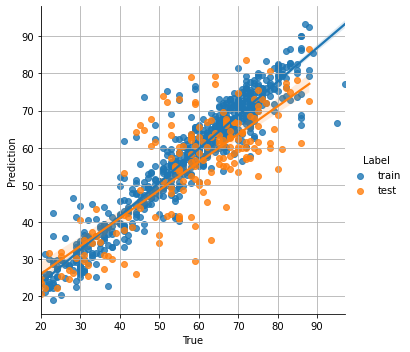

EPOCHS 39
RMSE :: [TRAIN] 3.516 | [VALID] 7.580
CORR :: [TRAIN] 0.952 | [VALID] 0.809


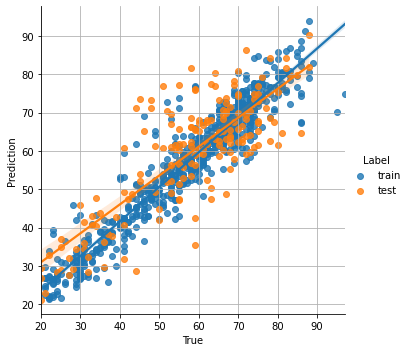

EPOCHS 40
RMSE :: [TRAIN] 3.578 | [VALID] 8.192
CORR :: [TRAIN] 0.952 | [VALID] 0.820


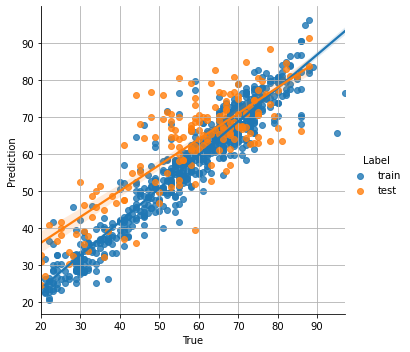

EPOCHS 41
RMSE :: [TRAIN] 3.567 | [VALID] 7.957
CORR :: [TRAIN] 0.953 | [VALID] 0.826


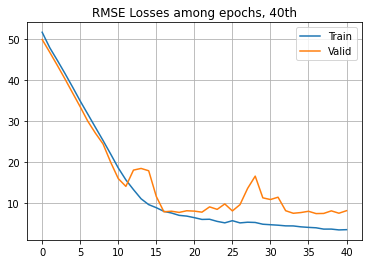

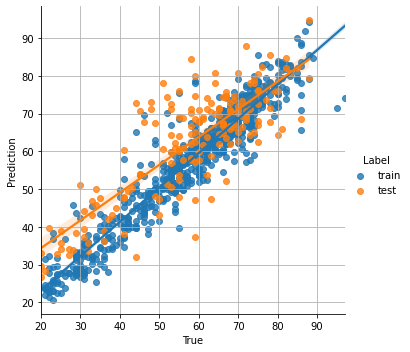

EPOCHS 42
RMSE :: [TRAIN] 3.640 | [VALID] 8.004
CORR :: [TRAIN] 0.951 | [VALID] 0.826


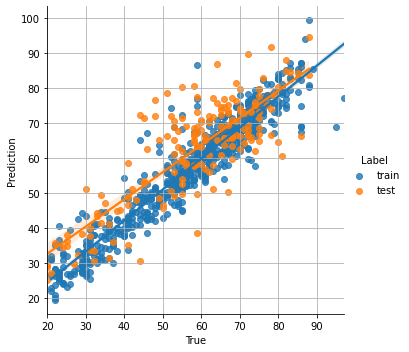

EPOCHS 43
RMSE :: [TRAIN] 3.360 | [VALID] 9.038
CORR :: [TRAIN] 0.958 | [VALID] 0.843


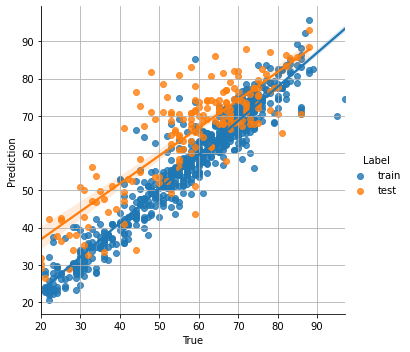

EPOCHS 44
RMSE :: [TRAIN] 3.115 | [VALID] 7.333
CORR :: [TRAIN] 0.961 | [VALID] 0.822


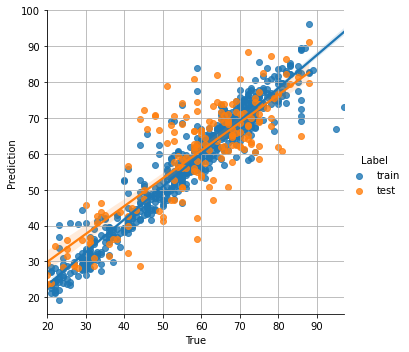

EPOCHS 45
RMSE :: [TRAIN] 3.129 | [VALID] 7.571
CORR :: [TRAIN] 0.961 | [VALID] 0.823


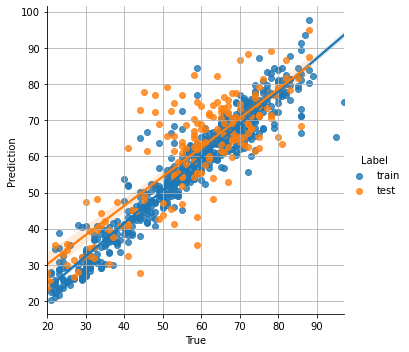

EPOCHS 46
RMSE :: [TRAIN] 3.248 | [VALID] 7.646
CORR :: [TRAIN] 0.960 | [VALID] 0.825


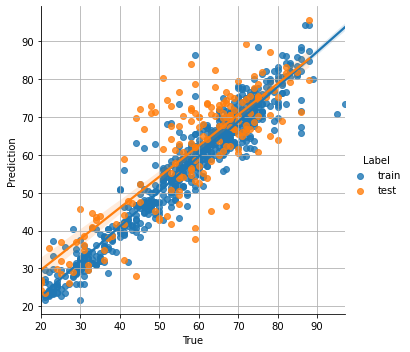

EPOCHS 47
RMSE :: [TRAIN] 3.128 | [VALID] 7.958
CORR :: [TRAIN] 0.961 | [VALID] 0.820


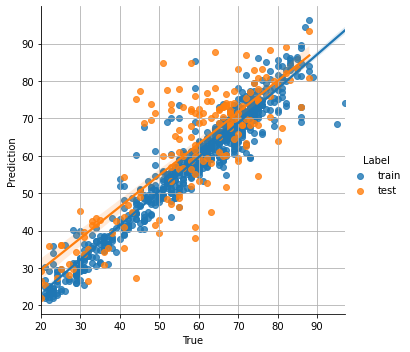

EPOCHS 48
RMSE :: [TRAIN] 3.034 | [VALID] 8.208
CORR :: [TRAIN] 0.964 | [VALID] 0.832


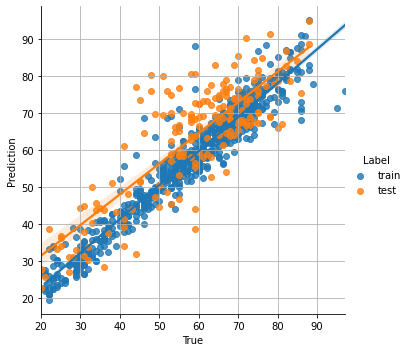

EPOCHS 49
RMSE :: [TRAIN] 3.231 | [VALID] 7.464
CORR :: [TRAIN] 0.961 | [VALID] 0.826


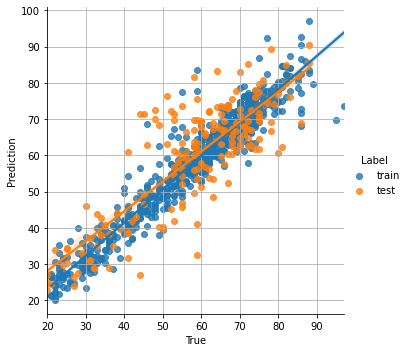

EPOCHS 50
RMSE :: [TRAIN] 2.945 | [VALID] 8.539
CORR :: [TRAIN] 0.965 | [VALID] 0.787


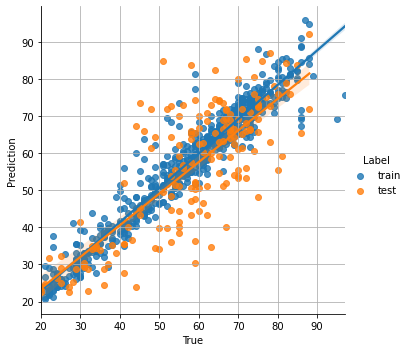

EPOCHS 51
RMSE :: [TRAIN] 2.979 | [VALID] 7.691
CORR :: [TRAIN] 0.965 | [VALID] 0.834


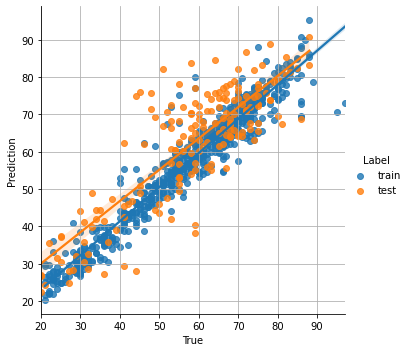

EPOCHS 52
RMSE :: [TRAIN] 2.826 | [VALID] 10.142
CORR :: [TRAIN] 0.969 | [VALID] 0.818


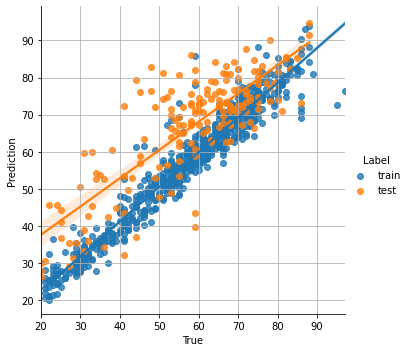

EPOCHS 53
RMSE :: [TRAIN] 2.826 | [VALID] 8.037
CORR :: [TRAIN] 0.968 | [VALID] 0.816


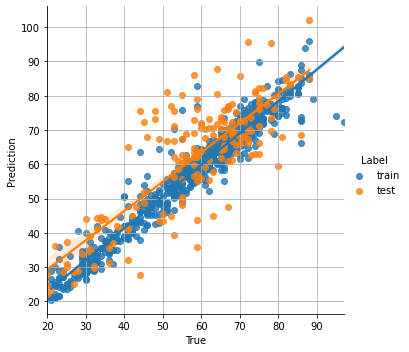

EPOCHS 54
RMSE :: [TRAIN] 2.781 | [VALID] 9.961
CORR :: [TRAIN] 0.969 | [VALID] 0.825


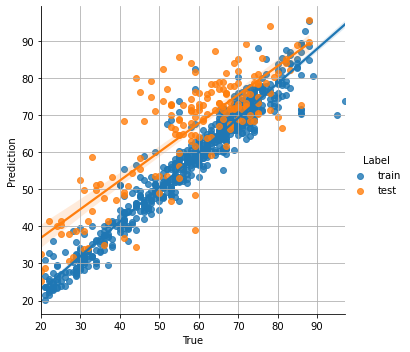

EPOCHS 55
RMSE :: [TRAIN] 2.747 | [VALID] 12.423
CORR :: [TRAIN] 0.970 | [VALID] 0.821


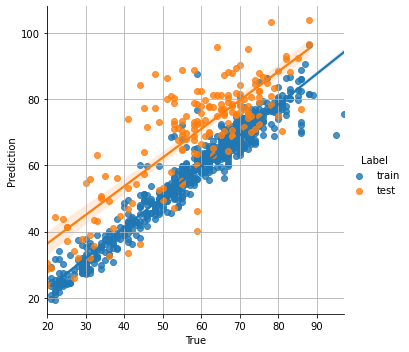

EPOCHS 56
RMSE :: [TRAIN] 2.838 | [VALID] 8.651
CORR :: [TRAIN] 0.969 | [VALID] 0.816


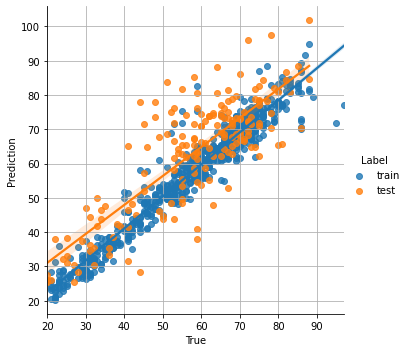

EPOCHS 57
RMSE :: [TRAIN] 2.838 | [VALID] 8.019
CORR :: [TRAIN] 0.968 | [VALID] 0.821


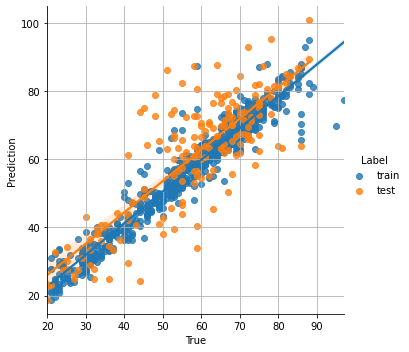

EPOCHS 58
RMSE :: [TRAIN] 2.754 | [VALID] 7.949
CORR :: [TRAIN] 0.970 | [VALID] 0.833


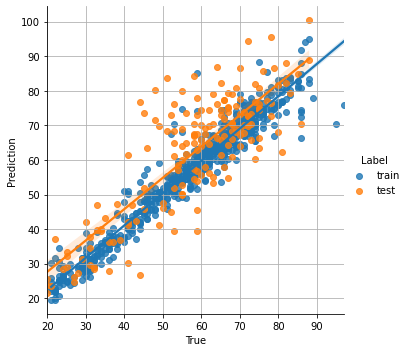

EPOCHS 59
RMSE :: [TRAIN] 2.906 | [VALID] 8.440
CORR :: [TRAIN] 0.967 | [VALID] 0.795


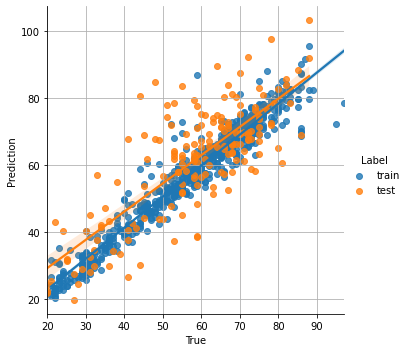

EPOCHS 60
RMSE :: [TRAIN] 2.788 | [VALID] 8.304
CORR :: [TRAIN] 0.971 | [VALID] 0.806


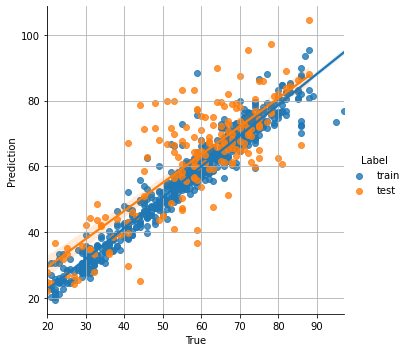

EPOCHS 61
RMSE :: [TRAIN] 2.680 | [VALID] 9.540
CORR :: [TRAIN] 0.971 | [VALID] 0.785


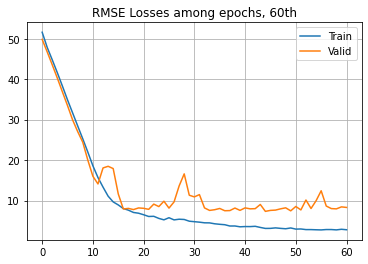

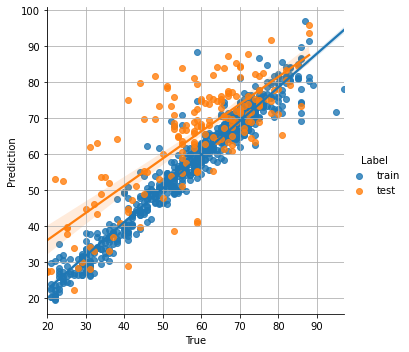

EPOCHS 62
RMSE :: [TRAIN] 2.971 | [VALID] 7.735
CORR :: [TRAIN] 0.966 | [VALID] 0.815


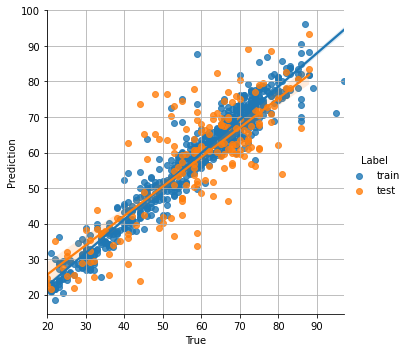

EPOCHS 63
RMSE :: [TRAIN] 2.711 | [VALID] 7.708
CORR :: [TRAIN] 0.970 | [VALID] 0.818


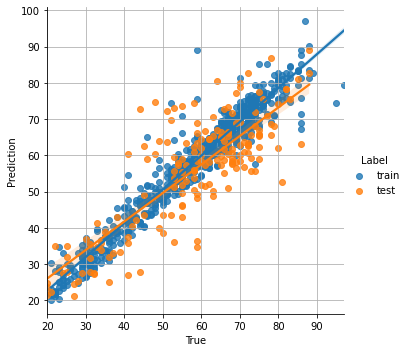

EPOCHS 64
RMSE :: [TRAIN] 2.859 | [VALID] 9.008
CORR :: [TRAIN] 0.967 | [VALID] 0.804


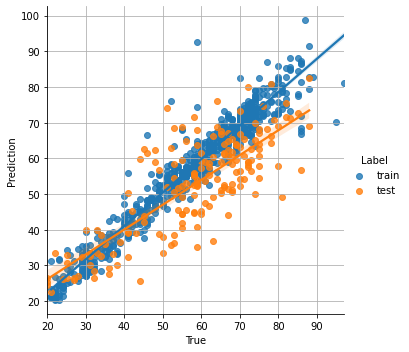

EPOCHS 65
RMSE :: [TRAIN] 2.706 | [VALID] 8.143
CORR :: [TRAIN] 0.971 | [VALID] 0.815


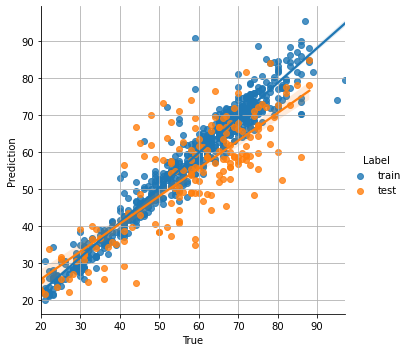

EPOCHS 66
RMSE :: [TRAIN] 2.423 | [VALID] 7.524
CORR :: [TRAIN] 0.975 | [VALID] 0.815


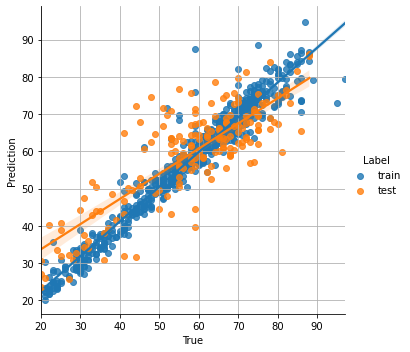

EPOCHS 67
RMSE :: [TRAIN] 2.489 | [VALID] 7.178
CORR :: [TRAIN] 0.974 | [VALID] 0.825


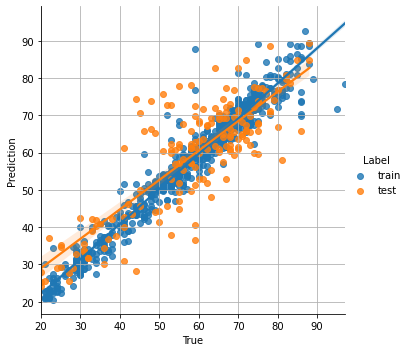

EPOCHS 68
RMSE :: [TRAIN] 2.459 | [VALID] 7.329
CORR :: [TRAIN] 0.976 | [VALID] 0.820


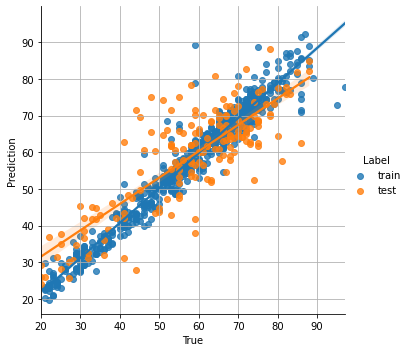

EPOCHS 69
RMSE :: [TRAIN] 2.528 | [VALID] 7.871
CORR :: [TRAIN] 0.976 | [VALID] 0.827


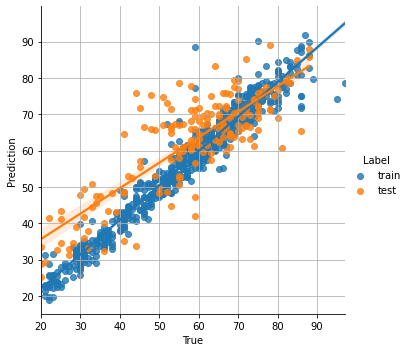

EPOCHS 70
RMSE :: [TRAIN] 2.612 | [VALID] 7.638
CORR :: [TRAIN] 0.974 | [VALID] 0.829


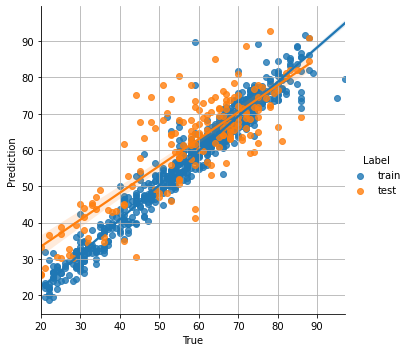

EPOCHS 71
RMSE :: [TRAIN] 2.483 | [VALID] 7.545
CORR :: [TRAIN] 0.975 | [VALID] 0.812


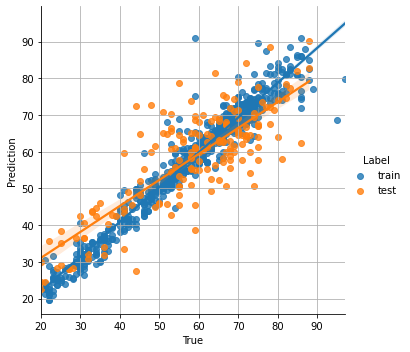

EPOCHS 72
RMSE :: [TRAIN] 2.548 | [VALID] 8.009
CORR :: [TRAIN] 0.974 | [VALID] 0.782


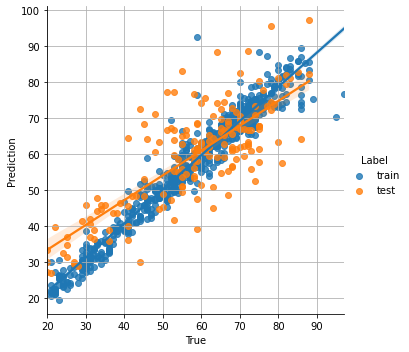

EPOCHS 73
RMSE :: [TRAIN] 2.642 | [VALID] 7.425
CORR :: [TRAIN] 0.973 | [VALID] 0.812


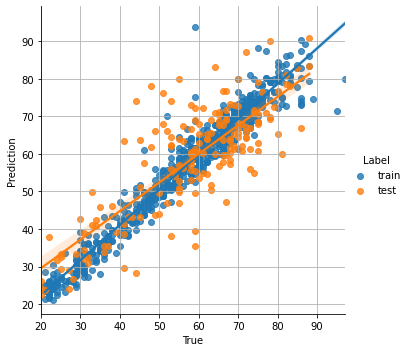

EPOCHS 74
RMSE :: [TRAIN] 2.478 | [VALID] 7.752
CORR :: [TRAIN] 0.974 | [VALID] 0.797


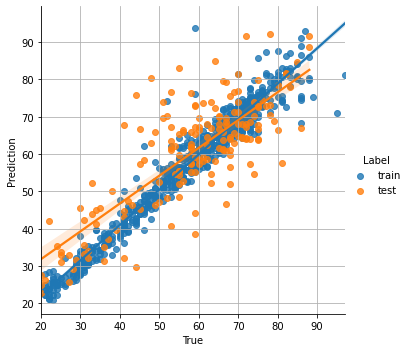

EPOCHS 75
RMSE :: [TRAIN] 2.591 | [VALID] 7.320
CORR :: [TRAIN] 0.973 | [VALID] 0.822


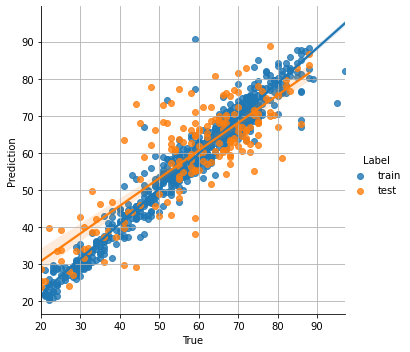

EPOCHS 76
RMSE :: [TRAIN] 2.417 | [VALID] 7.355
CORR :: [TRAIN] 0.975 | [VALID] 0.818


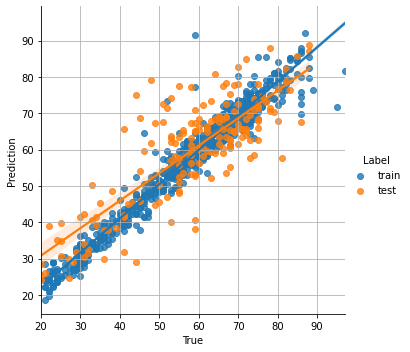

EPOCHS 77
RMSE :: [TRAIN] 2.514 | [VALID] 9.401
CORR :: [TRAIN] 0.974 | [VALID] 0.763


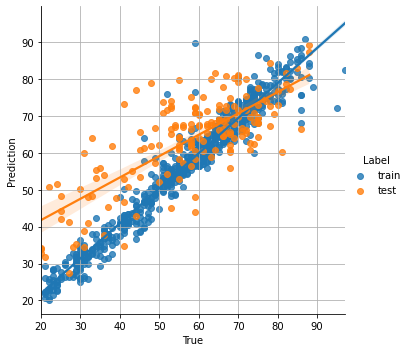

EPOCHS 78
RMSE :: [TRAIN] 2.370 | [VALID] 7.165
CORR :: [TRAIN] 0.977 | [VALID] 0.825


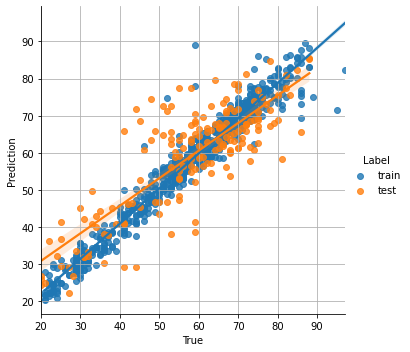

EPOCHS 79
RMSE :: [TRAIN] 2.062 | [VALID] 8.068
CORR :: [TRAIN] 0.980 | [VALID] 0.812


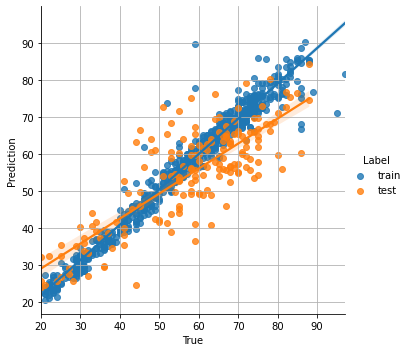

EPOCHS 80
RMSE :: [TRAIN] 2.131 | [VALID] 7.453
CORR :: [TRAIN] 0.980 | [VALID] 0.818


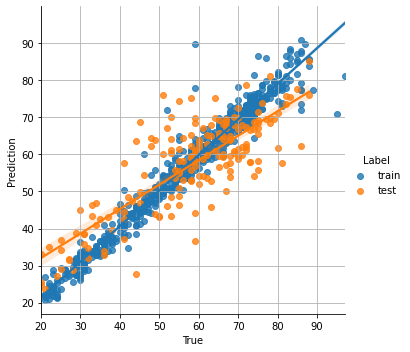

EPOCHS 81
RMSE :: [TRAIN] 2.307 | [VALID] 7.780
CORR :: [TRAIN] 0.978 | [VALID] 0.804


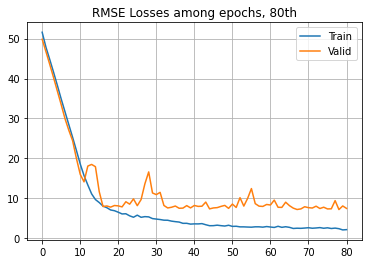

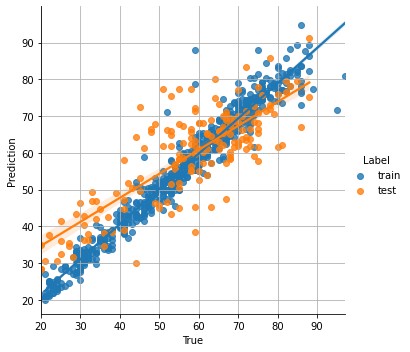

EPOCHS 82
RMSE :: [TRAIN] 2.269 | [VALID] 7.998
CORR :: [TRAIN] 0.979 | [VALID] 0.801


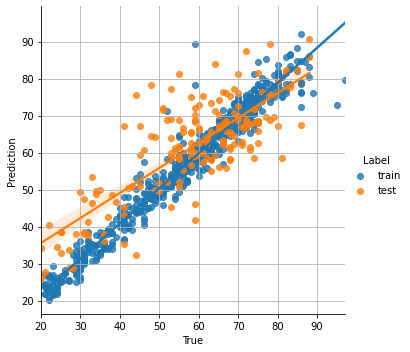

EPOCHS 83
RMSE :: [TRAIN] 1.940 | [VALID] 8.152
CORR :: [TRAIN] 0.983 | [VALID] 0.787


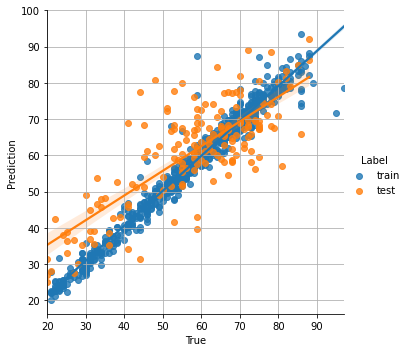

EPOCHS 84
RMSE :: [TRAIN] 2.289 | [VALID] 7.938
CORR :: [TRAIN] 0.979 | [VALID] 0.786


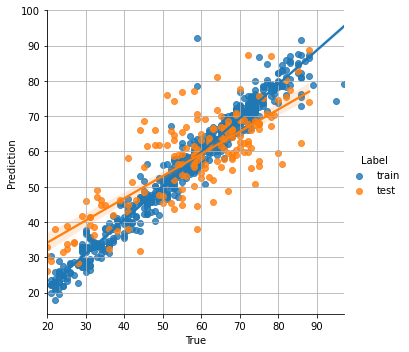

EPOCHS 85
RMSE :: [TRAIN] 2.083 | [VALID] 10.190
CORR :: [TRAIN] 0.982 | [VALID] 0.775


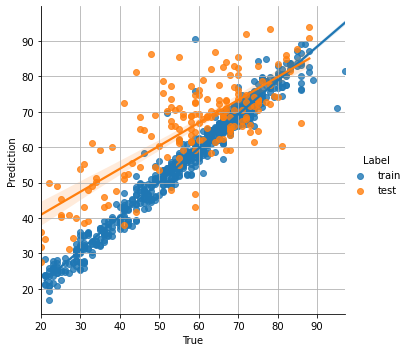

EPOCHS 86
RMSE :: [TRAIN] 2.200 | [VALID] 8.222
CORR :: [TRAIN] 0.979 | [VALID] 0.781


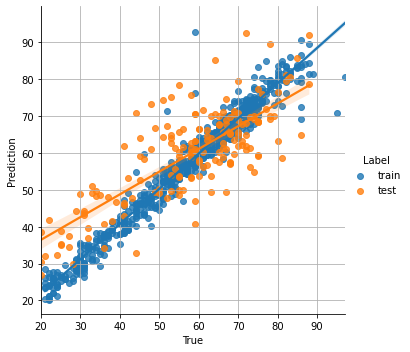

EPOCHS 87
RMSE :: [TRAIN] 2.327 | [VALID] 7.251
CORR :: [TRAIN] 0.978 | [VALID] 0.833


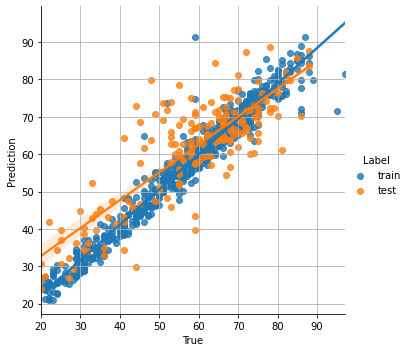

EPOCHS 88
RMSE :: [TRAIN] 2.465 | [VALID] 7.030
CORR :: [TRAIN] 0.976 | [VALID] 0.833


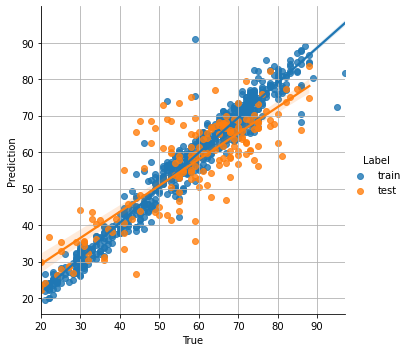

EPOCHS 89
RMSE :: [TRAIN] 2.186 | [VALID] 7.202
CORR :: [TRAIN] 0.981 | [VALID] 0.830


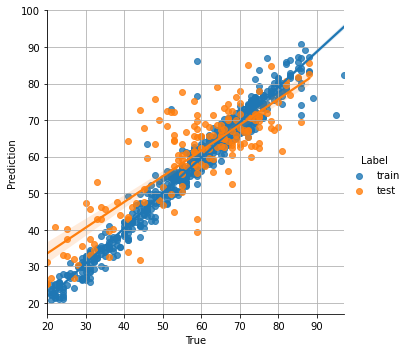

EPOCHS 90
RMSE :: [TRAIN] 2.011 | [VALID] 7.089
CORR :: [TRAIN] 0.983 | [VALID] 0.833


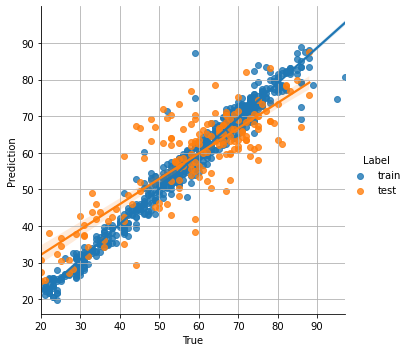

EPOCHS 91
RMSE :: [TRAIN] 1.925 | [VALID] 7.258
CORR :: [TRAIN] 0.985 | [VALID] 0.818


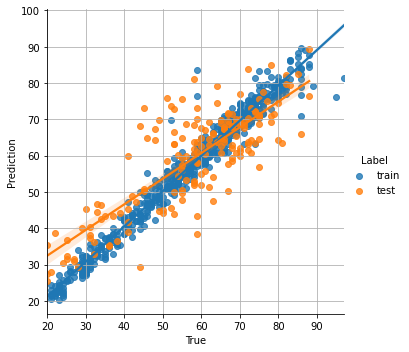

EPOCHS 92
RMSE :: [TRAIN] 2.115 | [VALID] 7.356
CORR :: [TRAIN] 0.983 | [VALID] 0.814


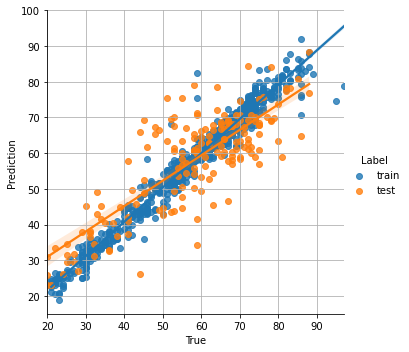

EPOCHS 93
RMSE :: [TRAIN] 1.808 | [VALID] 7.701
CORR :: [TRAIN] 0.986 | [VALID] 0.806


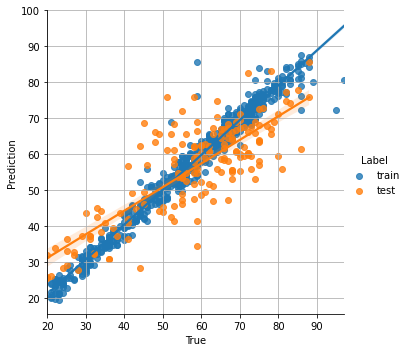

EPOCHS 94
RMSE :: [TRAIN] 1.983 | [VALID] 7.646
CORR :: [TRAIN] 0.984 | [VALID] 0.821


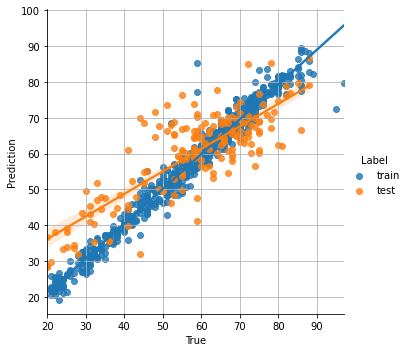

EPOCHS 95
RMSE :: [TRAIN] 1.854 | [VALID] 7.952
CORR :: [TRAIN] 0.986 | [VALID] 0.793


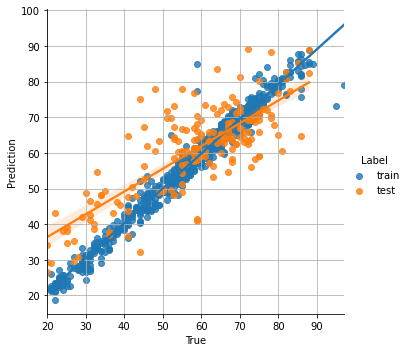

EPOCHS 96
RMSE :: [TRAIN] 1.941 | [VALID] 7.866
CORR :: [TRAIN] 0.985 | [VALID] 0.830


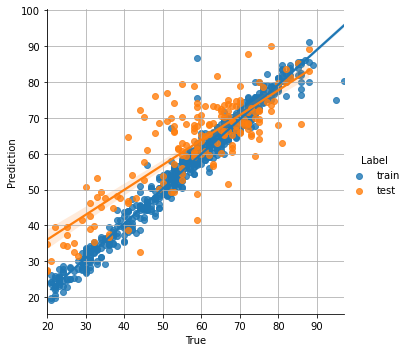

EPOCHS 97
RMSE :: [TRAIN] 1.563 | [VALID] 7.792
CORR :: [TRAIN] 0.988 | [VALID] 0.810


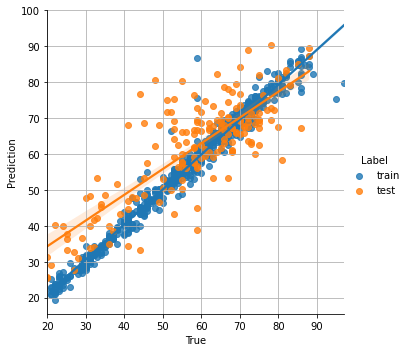

EPOCHS 98
RMSE :: [TRAIN] 1.792 | [VALID] 7.434
CORR :: [TRAIN] 0.986 | [VALID] 0.823


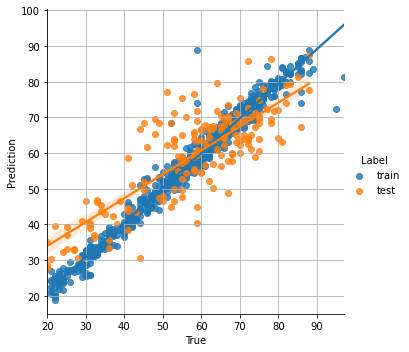

EPOCHS 99
RMSE :: [TRAIN] 1.749 | [VALID] 8.541
CORR :: [TRAIN] 0.987 | [VALID] 0.809


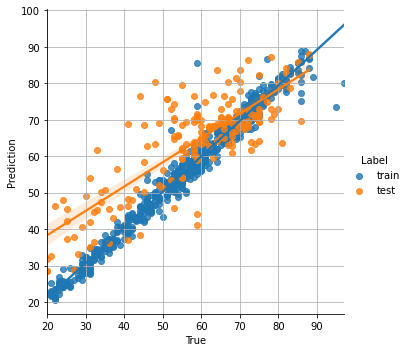

EPOCHS 100
RMSE :: [TRAIN] 1.725 | [VALID] 7.215
CORR :: [TRAIN] 0.987 | [VALID] 0.828


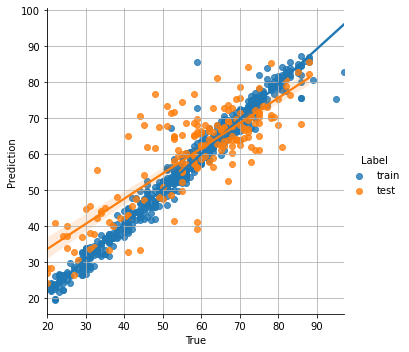

EPOCHS 101
RMSE :: [TRAIN] 1.745 | [VALID] 6.958
CORR :: [TRAIN] 0.988 | [VALID] 0.831


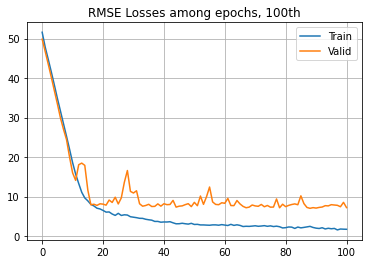

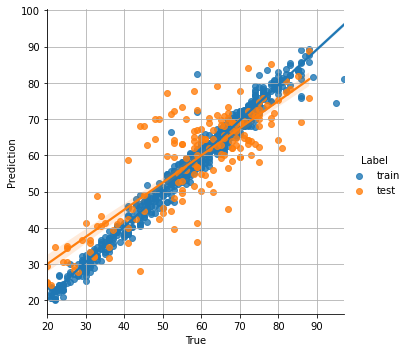

EPOCHS 102
RMSE :: [TRAIN] 1.610 | [VALID] 7.012
CORR :: [TRAIN] 0.989 | [VALID] 0.841


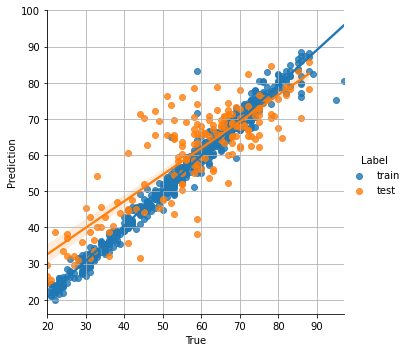

EPOCHS 103
RMSE :: [TRAIN] 1.755 | [VALID] 8.096
CORR :: [TRAIN] 0.988 | [VALID] 0.795


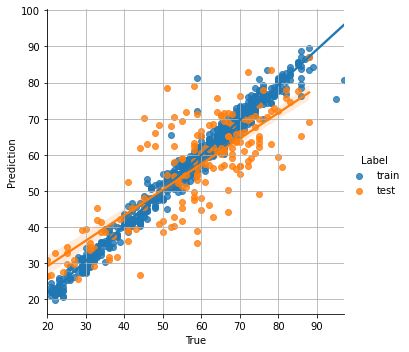

EPOCHS 104
RMSE :: [TRAIN] 1.865 | [VALID] 7.713
CORR :: [TRAIN] 0.987 | [VALID] 0.817


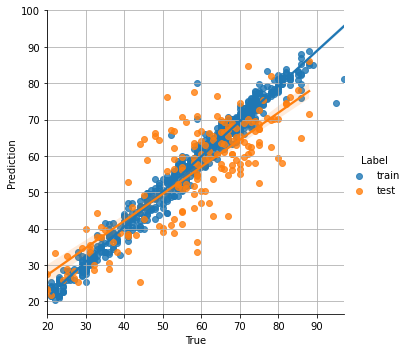

EPOCHS 105
RMSE :: [TRAIN] 1.768 | [VALID] 7.194
CORR :: [TRAIN] 0.988 | [VALID] 0.823


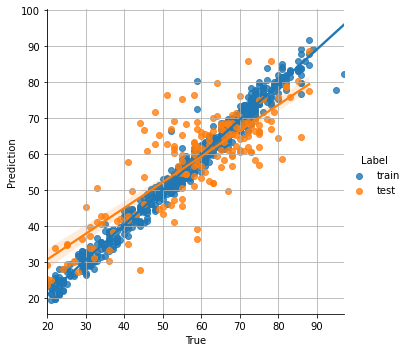

EPOCHS 106
RMSE :: [TRAIN] 1.798 | [VALID] 7.654
CORR :: [TRAIN] 0.988 | [VALID] 0.823


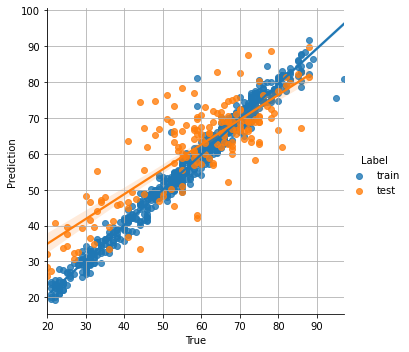

EPOCHS 107
RMSE :: [TRAIN] 1.657 | [VALID] 8.391
CORR :: [TRAIN] 0.989 | [VALID] 0.808


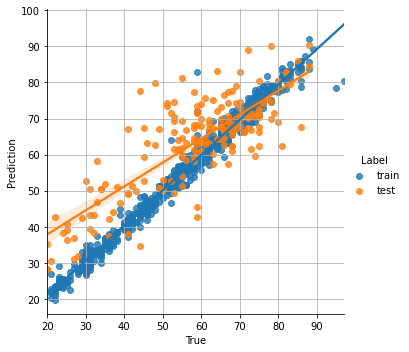

EPOCHS 108
RMSE :: [TRAIN] 1.718 | [VALID] 8.810
CORR :: [TRAIN] 0.989 | [VALID] 0.816


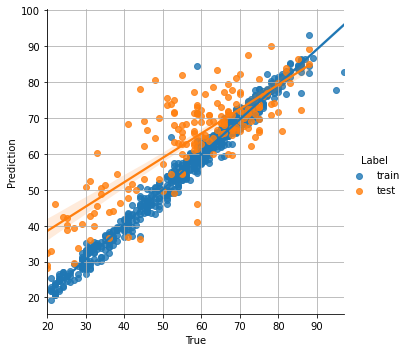

EPOCHS 109
RMSE :: [TRAIN] 1.840 | [VALID] 7.338
CORR :: [TRAIN] 0.987 | [VALID] 0.835


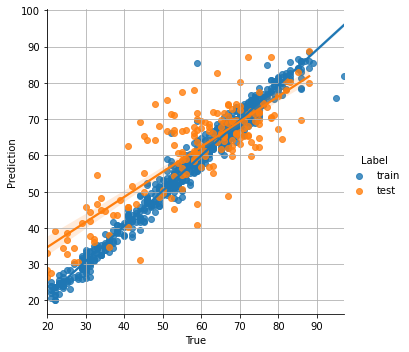

EPOCHS 110
RMSE :: [TRAIN] 1.645 | [VALID] 7.082
CORR :: [TRAIN] 0.989 | [VALID] 0.828


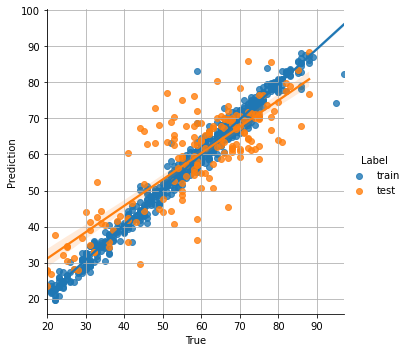

EPOCHS 111
RMSE :: [TRAIN] 1.734 | [VALID] 7.201
CORR :: [TRAIN] 0.989 | [VALID] 0.825


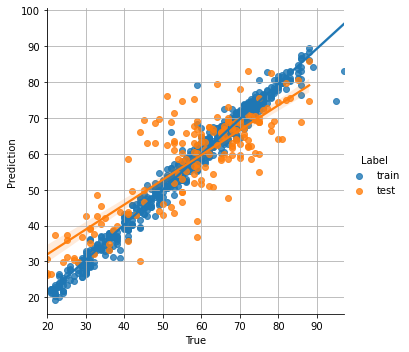

EPOCHS 112
RMSE :: [TRAIN] 1.500 | [VALID] 7.167
CORR :: [TRAIN] 0.991 | [VALID] 0.832


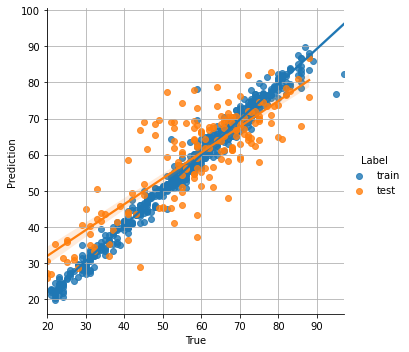

In [ ]:
trn_losses, tst_losses = [], []
best_loss = 10

for e in range(300):

    # TRAIN
    trn_bth_loss = 0
    trn_trues, trn_preds = [], []
    model.train()
    for i, (x, y) in enumerate(train_loader):

        if resize:
            x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

        else:
            x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x).to(device)

        trn_trues.append(y.to('cpu'))
        trn_preds.append(y_pred.to('cpu'))

#         loss = torch.sqrt(loss_fn(y_pred.squeeze(1), y)) # <- for MSE -> RMSE
        loss = loss_fn(y_pred.squeeze(1), y)
        del x, y, y_pred

        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()

        trn_bth_loss += loss.item()

    torch.cuda.empty_cache()
    
    ### loss
    trn_losses.append(trn_bth_loss / len(train_loader))

    ### collect trues/predictions
    trn_trues = list(chain(*trn_trues))
    trn_preds = list(chain(*trn_preds))

        
    # TEST
    tst_bth_loss = 0
    model.eval()
    tst_trues, tst_preds = [], []
    with torch.no_grad(): # to not give loads on GPU... :(
        for i, (x, y) in enumerate(test_loader):
            if resize:
                x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

            else:
                x, y = x.to(device), y.to(device)

            y_pred = model.forward(x).to(device)

            tst_trues.append(y.to('cpu'))
            tst_preds.append(y_pred.to('cpu'))

#             loss = torch.sqrt(loss_fn(y_pred.squeeze(1), y)) # <- for MSE -> RMSE
            loss = loss_fn(y_pred.squeeze(1), y)
            del x, y, y_pred

            tst_bth_loss += loss.item()

    torch.cuda.empty_cache()
    ### loss
    tst_losses.append(tst_bth_loss / len(test_loader))

    ### collect trues/predictions
    tst_trues = list(chain(*tst_trues))
    tst_preds = list(chain(*tst_preds))
    
    reg_df = pd.DataFrame({
        'True': list(map(float, trn_trues + tst_trues)),
        'Prediction': list(map(float, trn_preds + tst_preds)),
        'Label': ['train'] * len(trn_trues) + ['test'] * len(tst_trues)
    })
    
    trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
    tst_corr = reg_df[reg_df['Label'] == 'test' ].corr().Prediction['True']

    print(f'EPOCHS {e}')
    print(f'RMSE :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
    print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}')
    
    sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
    plt.grid()
    plt.show()
    
    if best_loss - .02 > tst_losses[-1]:
        
        date = f'{datetime.now().strftime("%Y-%m-%d_%H%M")}'
        fname = f"./models/{date}_{tst_losses[-1]:.3f}_model.pth"
        torch.save(model, fname)
        best_loss = min(tst_losses[-1], best_loss)
        
    summary.add_scalars('loss/RMSE_loss',
                         {'Train Loss': trn_losses[-1],
                          'Valid Loss': tst_losses[-1]}, e)
    summary.add_scalars('corr',
                       {'Train Correlation': trn_corr,
                        'Valid Correlation': tst_corr,
                        'Total Correlation': reg_df.corr().Prediction['True']}, e)
    
    if e % 20 == 0:
        plt.plot(trn_losses, label='Train')
        plt.plot(tst_losses, label='Valid')
        plt.title(f"RMSE Losses among epochs, {e}th")
        #plt.ylim(0, 500)
        plt.grid()
        plt.legend()

In [ ]:
best_loss

In [9]:
# plt.plot(trn_losses, label='Train')
# plt.plot(tst_losses, label='Valid')
# plt.title("RMSE Losses among epochs")
# # plt.hlines(min(tst_losses), color='red')
# #plt.ylim(0, 500)
# plt.grid()
# plt.legend()

In [10]:
# %load ../2d_slice/src/slice_viewer.py

In [11]:
# SliceViewer(np.array(train_dset[0][0][0])).triple_view()